# TD Deep Q-Network


Hédi Hadiji March 2023  
Adapted from Odalric Ambryn-Maillard

### Preliminary exercise: 

Below is the answer from ChatGPT to the query (March 2023)

```
    write a python implementation of q-learning
```


In [18]:
import numpy as np

# Define the environment
env = [[-1, -1, -1, -1, 0, -1],
       [-1, -1, -1, 0, -1, 100],
       [-1, -1, -1, 0, -1, -1],
       [-1, 0, 0, -1, 0, -1],
       [0, -1, -1, 0, -1, 100],
       [-1, 0, -1, -1, 0, 100]]

# Define the Q table
Q = np.zeros((6, 6))

# Define the hyperparameters
alpha = 0.8
gamma = 0.95
epsilon = 0.1
num_episodes = 1000

# Q-learning algorithm
for i in range(num_episodes):
    state = np.random.randint(0, 6)
    while state != 5:
        if np.random.rand() < epsilon:
            action = np.random.randint(0, 6)
        else:
            action = np.argmax(Q[state, :])
        next_state = np.argmax(env[state])
        reward = env[state][next_state]
        Q[state, action] = Q[state, action] + alpha * (reward + gamma * np.max(Q[next_state, :]) - Q[state, action])
        state = next_state

# Print the final Q table
print(Q)

[[ 95.          94.24        94.9696      94.848       91.2
   94.848     ]
 [100.          99.9936      99.9999488   99.99998976  99.99999992
   99.99998976]
 [ 90.25        90.22112     72.2         86.64        72.19999996
   72.2       ]
 [ 95.          94.848       94.99391844  94.99999992  94.9696
   94.99392   ]
 [100.          99.99872     99.99872     99.968       99.968
   99.968     ]
 [  0.           0.           0.           0.           0.
    0.        ]]


**Question 0** Comment on the code.

**Answer**  


The implementation is correct, but the state transitions are written in a misleading way, cf. the `next_state = np.argmax(env[state])`. 

The environment is not super interesting because it does not depend on the actions chosen: it is just deterministic walk on a graph 6 nodes. In particular this is not a gridworld.


In [19]:
import numpy as np

# Define the environment
env = [[-1, -1, -1, -1, 0, -1],
       [-1, -1, -1, 0, -1, 100],
       [-1, -1, -1, 0, -1, -1],
       [-1, 0, 0, -1, 0, -1],
       [0, -1, -1, 0, -1, 100],
       [-1, 0, -1, -1, 0, 100]]

# Define the Q table
Q = np.zeros((6, 6))

# Define the hyperparameters
alpha = 0.8
gamma = 0.95
epsilon = 0.1
num_episodes = 10

# Q-learning algorithm
for i in range(num_episodes):
    print('new_ep')
    state = np.random.randint(0, 6)
    while state != 5:
        print(state)
        if np.random.rand() < epsilon:
            action = np.random.randint(0, 6)
        else:
            action = np.argmax(Q[state, :])
        next_state = np.argmax(env[state])
        reward = env[state][next_state]
        Q[state, action] = Q[state, action] + alpha * (reward + gamma * np.max(Q[next_state, :]) - Q[state, action])
        state = next_state

# Print the final Q table
print(Q)

new_ep
1
new_ep
3
1
new_ep
new_ep
4
new_ep
new_ep
new_ep
4
new_ep
0
4
new_ep
4
new_ep
2
3
1
[[72.96   0.     0.     0.     0.     0.   ]
 [99.2    0.     0.     0.     0.     0.   ]
 [46.208  0.     0.     0.     0.     0.   ]
 [85.12   0.     0.     0.     0.     0.   ]
 [99.84   0.     0.     0.     0.     0.   ]
 [ 0.     0.     0.     0.     0.     0.   ]]


# Tutorial - Deep Q-Learning 

Deep Q-Learning uses a neural network to approximate $Q$ functions. Hence, we usually refer to this algorithm as DQN (for *deep Q network*).

The parameters of the neural network are denoted by $\theta$. 
*   As input, the network takes a state $s$,
*   As output, the network returns $Q_\theta [a | s] = Q_\theta (s,a) = Q(s, a, \theta)$, the value of each action $a$ in state $s$, according to the parameters $\theta$.


The goal of Deep Q-Learning is to learn the parameters $\theta$ so that $Q(s, a, \theta)$ approximates well the optimal $Q$-function $Q^*(s, a) \simeq Q_{\theta^*} (s,a)$. 

In addition to the network with parameters $\theta$, the algorithm keeps another network with the same architecture and parameters $\theta^-$, called **target network**.

The algorithm works as follows:

1.   At each time $t$, the agent is in state $s_t$ and has observed the transitions $(s_i, a_i, r_i, s_i')_{i=1}^{t-1}$, which are stored in a **replay buffer**.

2.  Choose action $a_t = \arg\max_a Q_\theta(s_t, a)$ with probability $1-\varepsilon_t$, and $a_t$=random action with probability $\varepsilon_t$. 

3. Take action $a_t$, observe reward $r_t$ and next state $s_t'$.

4. Add transition $(s_t, a_t, r_t, s_t')$ to the **replay buffer**.

4.  Sample a minibatch $\mathcal{B}$ containing $B$ transitions from the replay buffer. Using this minibatch, we define the loss:

$$
L(\theta) = \sum_{(s_i, a_i, r_i, s_i') \in \mathcal{B}}
\left[
Q(s_i, a_i, \theta) -  y_i
\right]^2
$$
where the $y_i$ are the **targets** computed with the **target network** $\theta^-$:

$$
y_i = r_i + \gamma \max_{a'} Q(s_i', a', \theta^-).
$$

5. Update the parameters $\theta$ to minimize the loss, e.g., with gradient descent (**keeping $\theta^-$ fixed**): 
$$
\theta \gets \theta - \eta \nabla_\theta L(\theta)
$$
where $\eta$ is the optimization learning rate. 

6. Every $N$ transitions ($t\mod N$ = 0), update target parameters: $\theta^- \gets \theta$.

7. $t \gets t+1$. Stop if $t = T$, otherwise go to step 2.

In [1]:
# Imports
import sys
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import numpy as np
import random
from copy import deepcopy
import gymnasium as gym


import time
import os
os.environ["SDL_VIDEODRIVER"] = "dummy"
from IPython.display import clear_output

import matplotlib.pyplot as plt

/Users/hedihadiji/opt/anaconda3/envs/pyRL/lib/python3.9/site-packages/gymnasium/envs/registration.py:521: UserWarning: WARN: Overriding environment GymV26Environment-v0 already in registry.
  logger.warn(f"Overriding environment {new_spec.id} already in registry.")
/Users/hedihadiji/opt/anaconda3/envs/pyRL/lib/python3.9/site-packages/gymnasium/envs/registration.py:521: UserWarning: WARN: Overriding environment GymV22Environment-v0 already in registry.
  logger.warn(f"Overriding environment {new_spec.id} already in registry.")


If necessary: install pytorch by running 

`pip3 install torch`

In [2]:
print(f"python --version = {sys.version}")
print(f"torch.__version__ = {torch.__version__}")
print(f"np.__version__ = {np.__version__}")
print(f"gym.__version__ = {gym.__version__}")

python --version = 3.9.15 (main, Nov 24 2022, 08:29:02) 
[Clang 14.0.6 ]
torch.__version__ = 2.0.0
np.__version__ = 1.22.4
gym.__version__ = 0.27.1


## Torch 101

>"The torch package contains data structures for multi-dimensional tensors and defines mathematical operations over these tensors. Additionally, it provides many utilities for efficient serializing of Tensors and arbitrary types, and other useful utilities. 
[...] provides classes and functions implementing automatic differentiation of arbitrary scalar valued functions." 
[PyTorch](https://pytorch.org/docs/stable/index.html)


### Variable types

In [22]:
# Very similar syntax to numpy.
zero_torch = torch.zeros((3, 2))

print('zero_torch is of type {:s}'.format(str(type(zero_torch))))

# Torch -> Numpy: simply call the numpy() method.
zero_np = np.zeros((3, 2))
assert (zero_torch.numpy() == zero_np).all()

# Numpy -> Torch: simply call the corresponding function on the np.array.
zero_torch_float = torch.FloatTensor(zero_np)
print('\nFloat:\n', zero_torch_float)
zero_torch_int = torch.LongTensor(zero_np)
print('Int:\n', zero_torch_int)
zero_torch_bool = torch.BoolTensor(zero_np)
print('Bool:\n', zero_torch_bool)

# Reshape
print('\nView new shape...', zero_torch.view(1, 6))
# Note that print(zero_torch.reshape(1, 6)) would work too.
# The difference is in how memory is handled (view imposes contiguity).

# Algebra
a = torch.randn((3, 2))
b = torch.randn((3, 2))
print('\nAlgebraic operations are overloaded:\n', a, '\n+\n', b, '\n=\n', a+b )

# More generally, torch shares the syntax of many attributes and functions with Numpy.

zero_torch is of type <class 'torch.Tensor'>

Float:
 tensor([[0., 0.],
        [0., 0.],
        [0., 0.]])
Int:
 tensor([[0, 0],
        [0, 0],
        [0, 0]])
Bool:
 tensor([[False, False],
        [False, False],
        [False, False]])

View new shape... tensor([[0., 0., 0., 0., 0., 0.]])

Algebraic operations are overloaded:
 tensor([[ 0.6944,  0.9056],
        [-0.7263, -1.0217],
        [-0.5614, -0.0928]]) 
+
 tensor([[-0.2529,  0.0222],
        [ 1.1547,  0.7548],
        [ 0.2974,  0.0070]]) 
=
 tensor([[ 0.4415,  0.9278],
        [ 0.4284, -0.2669],
        [-0.2640, -0.0858]])


### Gradient management

In [23]:
# torch.Tensor is a similar yet more complicated data structure than np.array.
# It is basically a static array of number but may also contain an overlay to 
# handle automatic differentiation (i.e keeping track of the gradient and which 
# tensors depend on which).
# To access the static array embedded in a tensor, simply call the detach() method
print(zero_torch.detach())

# When inside a function performing automatic differentiation (basically when training 
# a neural network), never use detach() otherwise meta information regarding gradients
# will be lost, effectively freezing the variable and preventing backprop for it. 
# However when returning the result of training, do use detach() to save memory 
# (the naked tensor data uses much less memory than the full-blown tensor with gradient
# management, and is much less prone to mistake such as bad copy and memory leak).

# We will solve theta * x = y in theta for x=1 and y=2
x = torch.ones(1)
y = 2 * torch.ones(1)

# Actually by default torch does not add the gradient management overlay
# when declaring tensors like this. To force it, add requires_grad=True.
theta = torch.randn(1, requires_grad=True)

# Optimisation routine
# (Adam is a sophisticated variant of SGD, with adaptive step).
optimizer = optim.Adam(params=[theta], lr=0.1)

# Loss function
print('Initial guess:', theta.detach())

for _ in range(100):
    # By default, torch accumulates gradients in memory.
    # To obtain the desired gradient descent beahviour,
    # just clean the cached gradients using the following line:
    optimizer.zero_grad()
    
    # Quadratic loss (* and ** are overloaded so that torch
    # knows how to differentiate them)
    loss = (y - theta * x) ** 2
    
    # Apply the chain rule to automatically compute gradients
    # for all relevant tensors.
    loss.backward()
    
    # Run one step of optimisation routine.
    optimizer.step()
    
print('Final estimate:', theta.detach())
print('The final estimate should be close to', y)

tensor([[0., 0.],
        [0., 0.],
        [0., 0.]])
Initial guess: tensor([-0.5508])
Final estimate: tensor([1.9998])
The final estimate should be close to tensor([2.])


# Setting up the DQN agent

### 1 - Replay buffer

In [24]:
class ReplayBuffer:
    def __init__(self, capacity):
        self.capacity = capacity
        self.memory = []
        self.position = 0

    def push(self, state, action, reward, terminated, next_state):
        """Saves a transition."""
        if len(self.memory) < self.capacity:
            self.memory.append(None)
        self.memory[self.position] = (state, action, reward, terminated, next_state)
        self.position = (self.position + 1) % self.capacity

    def sample(self, batch_size):
        return random.choices(self.memory, k=batch_size)

    def __len__(self):
        return len(self.memory)

# create instance of replay buffer
#replay_buffer = ReplayBuffer(BUFFER_CAPACITY)

### 2 - Neural Network

In [25]:
class Net(nn.Module):
    """
    Basic neural net.
    """
    def __init__(self, obs_size, hidden_size, n_actions):
        super(Net, self).__init__()
        self.net = nn.Sequential(
            nn.Linear(obs_size, hidden_size),
            nn.ReLU(),
            nn.Linear(hidden_size, n_actions)
        )

    def forward(self, x):
        return self.net(x)

### 2.5 - Loss function and optimizer

In [26]:
class DQN_Skeleton: 
    def __init__(self,
                action_space,
                observation_space,
                gamma,
                batch_size,
                buffer_capacity,
                update_target_every, 
                epsilon_start, 
                decrease_epsilon_factor, 
                epsilon_min,
                learning_rate,
                ): 
        self.action_space = action_space
        self.observation_space = observation_space
        self.gamma = gamma
        
        self.batch_size = batch_size
        self.buffer_capacity = buffer_capacity
        self.update_target_every = update_target_every
        
        self.epsilon_start = epsilon_start
        self.decrease_epsilon_factor = decrease_epsilon_factor # larger -> more exploration
        self.epsilon_min = epsilon_min
        
        self.learning_rate = learning_rate
        
        self.reset()
        
    def get_action(self, state):
        """
        ** TO BE IMPLEMENTED LATER**

        Return action according to an epsilon-greedy exploration policy
        """
        pass
    
    def update(self, *data):
        """
        ** TO BE IMPLEMENTED LATER **

        Updates the buffer and the network(s)
        """
        pass
    
    def get_q(self, state):
        """
        Compute Q function for a states
        """
        state_tensor = torch.tensor(state).unsqueeze(0)
        with torch.no_grad():
            output = self.q_net.forward(state_tensor) # shape (1,  n_actions)
        return output.numpy()[0]  # shape  (n_actions)
    
    def decrease_epsilon(self):
        self.epsilon = self.epsilon_min + (self.epsilon_start - self.epsilon_min) * (
                        np.exp(-1. * self.n_eps / self.decrease_epsilon_factor ) )
    
    def reset(self):
        hidden_size = 128
        
        obs_size = self.observation_space.shape[0]
        n_actions = self.action_space.n
        
        self.buffer = ReplayBuffer(self.buffer_capacity)
        self.q_net =  Net(obs_size, hidden_size, n_actions)
        self.target_net = Net(obs_size, hidden_size, n_actions)
        
        self.loss_function = nn.MSELoss()
        self.optimizer = optim.Adam(params=self.q_net.parameters(), lr=self.learning_rate)
        
        self.epsilon = self.epsilon_start
        self.n_steps = 0
        self.n_eps = 0
    

In [27]:
class RandomAgent: 
    def __init__(self, observation_space, action_space):
        self.action_space = action_space
        return
    
    def get_action(self, state, *args):
        return self.action_space.sample()
    
    def update(self, *data):
        pass

## Implementing the DQN

#### Question 1

Implement the `get_action` function.

In [28]:
class DQN_SkeletonI(DQN_Skeleton):   
    def get_action(self, state, epsilon=None):
        """
        ** TO BE IMPLEMENTED NOW**

        Return action according to an epsilon-greedy exploration policy
        """
        if epsilon is None: 
            epsilon = self.epsilon
            
        # Your code here
        pass

In [29]:
class DQN_SkeletonI(DQN_Skeleton):   
    def get_action(self, state, epsilon=None):
        """
            ** Solution ** 
        
            Return action according to an epsilon-greedy exploration policy
        """
        if epsilon is None: 
            epsilon = self.epsilon
            
        if np.random.rand() < epsilon: 
            return env.action_space.sample()
        else: 
            return np.argmax(self.get_q(state))

#### Question 2

Implement the `eval_dqn` function.

In [30]:
def eval_agent(agent, env, n_sim=5):
    """
    ** TO BE IMPLEMENTED **
    
    Monte Carlo evaluation of DQN agent.

    Repeat n_sim times:
        * Run the DQN policy until the environment reaches a terminal state (= one episode)
        * Compute the sum of rewards in this episode
        * Store the sum of rewards in the episode_rewards array.
    """
    env_copy = deepcopy(env)
    episode_rewards = np.zeros(n_sim)
    # Your code here
    return episode_rewards

In [31]:
def eval_agent(agent, env, n_sim=5):
    """
    ** Solution **
    
    Monte Carlo evaluation of DQN agent.

    Repeat n_sim times:
        * Run the DQN policy until the environment reaches a terminal state (= one episode)
        * Compute the sum of rewards in this episode
        * Store the sum of rewards in the episode_rewards array.
    """
    env_copy = deepcopy(env)
    episode_rewards = np.zeros(n_sim)
    for i in range(n_sim):
        state, _ = env_copy.reset()
        reward_sum = 0
        done = False
        while not done: 
            action = agent.get_action(state, 0)
            state, reward, terminated, truncated, _ = env_copy.step(action)
            reward_sum += reward
            done = terminated or truncated
        episode_rewards[i] = reward_sum
    return episode_rewards

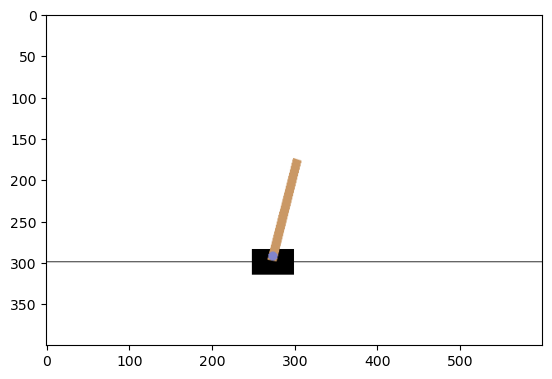

Episode length 15.0
Average over 5 runs : 20.8


In [32]:
env = env = gym.make("CartPole-v1", render_mode='rgb_array')
agent = RandomAgent(env.observation_space, env.action_space)

def run_one_episode(env, agent, display=True):
    display_env = deepcopy(env)
    done = False
    state, _ = display_env.reset()

    rewards = 0

    while not done:
        action = agent.get_action(state, 0)
        state, reward, done, _, _ = display_env.step(action)
        rewards += reward
        if display: 
            clear_output(wait=True)
            plt.imshow(display_env.render())
            plt.show()
    if display:
        display_env.close()
    print(f'Episode length {rewards}')
    
run_one_episode(env, agent, display=True)
print(f'Average over 5 runs : {np.mean(eval_agent(agent, env))}')

#### Question 3

Implement the `update` function

In [33]:
class DQN(DQN_SkeletonI):   
    def update(self, state, action, reward, terminated, next_state):
        """
        ** TO BE COMPLETED **
        """

        # add data to replay buffer
        self.buffer.push(torch.tensor(state).unsqueeze(0), 
                           torch.tensor([[action]], dtype=torch.int64), 
                           torch.tensor([reward]), 
                           torch.tensor([terminated], dtype=torch.int64), 
                           torch.tensor(next_state).unsqueeze(0),
                          )

        if len(self.buffer) < self.batch_size:
            return np.inf

        # get batch
        transitions = self.buffer.sample(self.batch_size)

        state, action, reward, terminated, next_state = transition
        val = self.q_net.forward(state)[action]
        target = (not terminated) * (reward + self.gamma * np.max(self.q_net.forward(next_state)))
        loss = self.loss(val, target)

        # Compute loss - TO BE IMPLEMENTED!
        # Hint: use the gather method from torch.

        
        # Optimize the model 
        loss.backward()
        self.optimizer.step()
        

        return loss.detach().numpy()

In [34]:
class DQN(DQN_SkeletonI):   
    def update(self, state, action, reward, terminated, next_state):
        """
        ** SOLUTION **
        """

        # add data to replay buffer
        self.buffer.push(torch.tensor(state).unsqueeze(0), 
                           torch.tensor([[action]], dtype=torch.int64), 
                           torch.tensor([reward]), 
                           torch.tensor([terminated], dtype=torch.int64), 
                           torch.tensor(next_state).unsqueeze(0),
                          )

        if len(self.buffer) < self.batch_size:
            return np.inf

        # get batch
        transitions = self.buffer.sample(self.batch_size)

        # Compute loss - TO BE IMPLEMENTED!
        # Hint: use the gather method from torch.

        state_batch, action_batch, reward_batch, terminated_batch, next_state_batch = tuple(
            [torch.cat(data) for data in zip(*transitions)]
        )

        values  = self.q_net.forward(state_batch).gather(1, action_batch)

        # Compute the ideal Q values
        with torch.no_grad():
            next_state_values = (1 - terminated_batch) * self.target_net(next_state_batch).max(1)[0]
            targets = next_state_values * self.gamma + reward_batch

        loss = self.loss_function(values, targets.unsqueeze(1))

        # Optimize the model 
        self.optimizer.zero_grad()
        loss.backward()
        #torch.nn.utils.clip_grad_value_(self.q_net.parameters(), 100)
        self.optimizer.step()
        
        if not((self.n_steps+1) % self.update_target_every): 
            self.target_net.load_state_dict(self.q_net.state_dict())
            
        self.decrease_epsilon()
            
        self.n_steps += 1
        if terminated: 
            self.n_eps += 1

        return loss.detach().numpy()

#### Question 4
Train a DQN on the `env` environment.
*Hint* The mean reward after training should be close to 200.

episode = 10 , reward =  13.4
episode = 20 , reward =  95.0
episode = 30 , reward =  59.4
episode = 40 , reward =  87.0
episode = 50 , reward =  64.6
episode = 60 , reward =  131.0
episode = 70 , reward =  106.8
episode = 80 , reward =  109.8
episode = 90 , reward =  65.2
episode = 100 , reward =  86.8
episode = 110 , reward =  223.6
episode = 120 , reward =  116.8
episode = 130 , reward =  178.6
episode = 140 , reward =  101.8
episode = 150 , reward =  99.8
episode = 160 , reward =  264.8
episode = 170 , reward =  114.2
episode = 180 , reward =  90.4
episode = 190 , reward =  91.4
episode = 200 , reward =  120.2
episode = 210 , reward =  105.8
episode = 220 , reward =  352.4

mean reward after training =  350.8


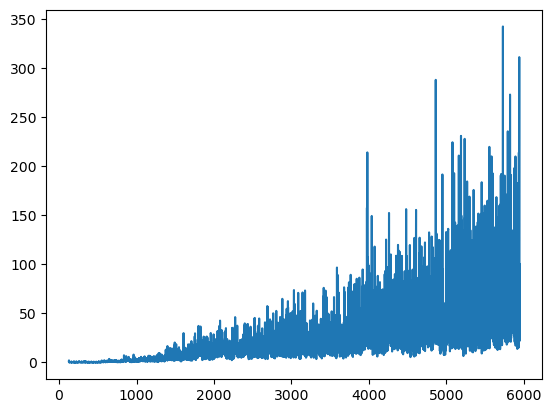

In [35]:
env = gym.make("CartPole-v1", render_mode='rgb_array')

action_space = env.action_space
observation_space = env.observation_space

gamma = 0.99
batch_size = 128
buffer_capacity = 10_000
update_target_every = 32

epsilon_start = 0.9
decrease_epsilon_factor = 1000
epsilon_min = 0.05

learning_rate = 1e-1

arguments = (action_space,
            observation_space,
            gamma,
            batch_size,
            buffer_capacity,
            update_target_every, 
            epsilon_start, 
            decrease_epsilon_factor, 
            epsilon_min,
            learning_rate,
        )

N_episodes = 300

agent = DQN(*arguments)


def train(env, agent, N_episodes, eval_every=10, reward_threshold=300):
    total_time = 0
    state, _ = env.reset()
    losses = []
    for ep in range(N_episodes):
        done = False
        state, _ = env.reset()
        while not done: 
            action = agent.get_action(state)

            next_state, reward, terminated, truncated, _ = env.step(action)
            loss_val = agent.update(state, action, reward, terminated, next_state)

            state = next_state
            losses.append(loss_val)

            done = terminated or truncated
            total_time += 1

        if ((ep+1)% eval_every == 0):
            rewards = eval_agent(agent, env)
            print("episode =", ep+1, ", reward = ", np.mean(rewards))
            if np.mean(rewards) >= reward_threshold:
                break
                
    return losses

    
# Run the training loop
losses = train(env, agent, N_episodes)

plt.plot(losses)

# Evaluate the final policy
rewards = eval_agent(agent, env, 20)
print("")
print("mean reward after training = ", np.mean(rewards))

In [39]:
print("Rewards after training = ", eval_agent(agent, env))

Rewards after training =  [500. 500. 500. 500. 500.]


#### Question 5

Experiment the policy network.

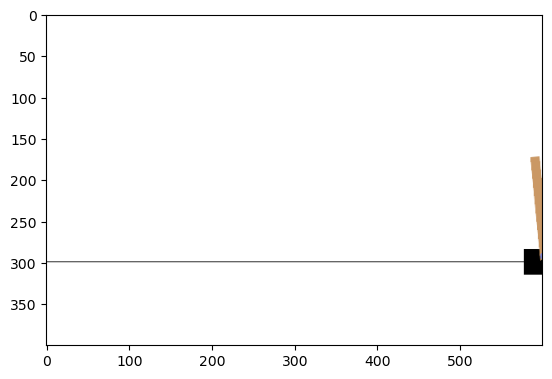

Episode length 365.0


In [36]:
run_one_episode(env, agent, display=True)

### Experiments: Do It Yourself

Remember the set of parameters:
```
# Environment
env = gym.make("CartPole-v1")

gamma = 0.99
batch_size = 32
buffer_capacity = 10_000
update_target_every = 32

epsilon_start = 0.9
decrease_epsilon_factor = 200
epsilon_min = 0.05

learning_rate = 1e-2
```

#### Question 6

Craft an experiment and study the influence of the `BUFFER_CAPACITY` on the learning process (speed of *convergence*, training curves...) 

#### Question 7

Craft an experiment and study the influence of the `UPDATE_TARGET_EVERY` on the learning process (speed of *convergence*, training curves...) 

#### Question 8

If you have the computer power to do so, try to do a grid search on those two hyper-parameters and comment the results. Otherwise, study the influence of another hyper-parameter.

## Discretization

It is natural to use a function approximator like a neural network to approximate the $Q$ function in a continuous environment. Another natural but unscalable way to do handle continuous state-action space is **discretization**.

Discretize the environment of your choice (cartpole or mountain car or both) and run one of the algorithms that you know to compute an approximation of the optimal $Q$ function.

Once you are satisfied with your results, you may plot the *optimal phase diagram* of the system. For instance, you may get something like this for the mountain car environment.
![Phase diagram](./phase_plot.png)

In [ ]:
# TODO: Everything! This is an introduction to research and development

episode = 50 , reward =  -200.0
episode = 100 , reward =  -200.0
episode = 150 , reward =  -200.0
episode = 200 , reward =  -200.0
episode = 250 , reward =  -200.0
episode = 300 , reward =  -200.0
episode = 350 , reward =  -200.0
episode = 400 , reward =  -200.0
episode = 450 , reward =  -200.0
episode = 500 , reward =  -200.0
episode = 550 , reward =  -200.0
episode = 600 , reward =  -200.0
episode = 650 , reward =  -200.0
episode = 700 , reward =  -200.0
episode = 750 , reward =  -200.0
episode = 800 , reward =  -200.0
episode = 850 , reward =  -200.0
episode = 900 , reward =  -200.0
episode = 950 , reward =  -200.0
episode = 1000 , reward =  -200.0
episode = 1050 , reward =  -200.0
episode = 1100 , reward =  -200.0
episode = 1150 , reward =  -200.0
episode = 1200 , reward =  -200.0
episode = 1250 , reward =  -200.0
episode = 1300 , reward =  -200.0
episode = 1350 , reward =  -200.0
episode = 1400 , reward =  -200.0
episode = 1450 , reward =  -200.0
episode = 1500 , reward =  -200.0


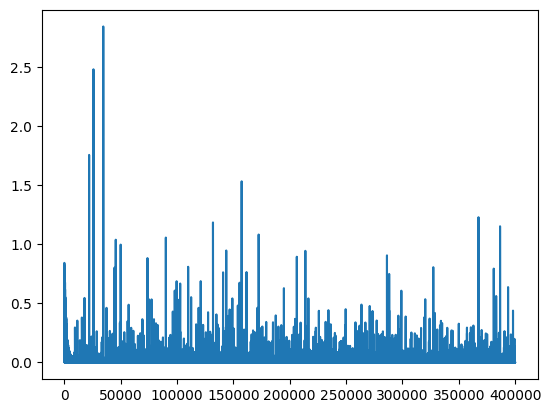

In [177]:
env = gym.make("MountainCar-v0", render_mode='rgb_array')


action_space = env.action_space
observation_space = env.observation_space

gamma = 0.99
batch_size = 32
buffer_capacity = 10_000
update_target_every = 32

epsilon_start = 0.9
decrease_epsilon_factor = 1000
epsilon_min = 0.05

learning_rate = 1e-2

arguments = (action_space,
            observation_space,
            gamma,
            batch_size,
            buffer_capacity,
            update_target_every, 
            epsilon_start, 
            decrease_epsilon_factor, 
            epsilon_min,
            learning_rate,
        )

N_episodes = 2000

agent = DQN(*arguments)

    
# Run the training loop
losses = train(env, agent, N_episodes, eval_every=50)

plt.plot(losses)

# Evaluate the final policy
rewards = eval_agent(agent, env, 20)
print("")
print("mean reward after training = ", np.mean(rewards))

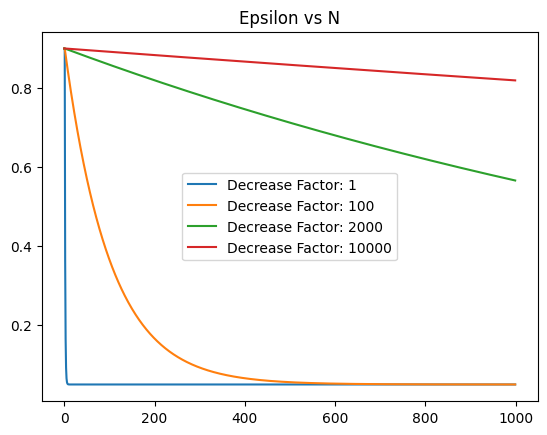

In [176]:
for decrease_factor in [1, 100, 2000, 10_000]:
    arguments = (action_space,
                observation_space,
                gamma,
                batch_size,
                buffer_capacity,
                update_target_every, 
                0.9, 
                decrease_factor, 
                0.05,
                learning_rate,
            )

    test_agent = DQN(*arguments)
    epss = []
    N = 1000

    for _ in range(N):
        epss.append(test_agent.epsilon)
        test_agent.decrease_epsilon()
        test_agent.n_eps += 1

    plt.plot(epss, label=f'Decrease Factor: {decrease_factor}')
plt.title('Epsilon vs N')
plt.legend()
plt.show()
